# Introduction to swyft-lightning

In this notebook, we will go through the basic steps of performing parameter inference with Swyft.

## Setup

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
N = 100000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2)**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.1

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [4]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals, varnames = 'z')

    def forward(self, A, B):
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [6]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 3, precision = 64)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [7]:
dl_train = samples[:-500].get_dataloader(batch_size = 256, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 256)

In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 52.2 K
1 | logratios2 | LogRatioEstimator_Ndim | 17.5 K
------------------------------------------------------
69.7 K    Trainable params
0         Non-trainable params
69.7 K    Total params
0.558     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9929809/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 389/391 [00:06<00:00, 60.45it/s, loss=-0.869, v_num=9929809]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 389/391 [00:06<00:00, 60.65it/s, loss=-0.901, v_num=9929809, val_loss=-.808]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 389/391 [00:06<00:00, 60.19it/s, loss=-0.891, v_num=9929809, val_loss=-.835]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 391/391 [00:06<00:00, 60.02it/s, loss=-0.891, v_num=9929809, val_loss=-.811]


## Inference

We assume that we measure the values $x=0.2$.

In [10]:
x0 = 0.5

We first generate a large number of prior samples.

In [11]:
B = swyft.Samples(z = np.random.rand(1000000, 3)*2-1)

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [12]:
A = swyft.Sample(x = np.array([x0]))

In [13]:
predictions = trainer.infer(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting:  41%|████      | 401/977 [00:00<00:04, 118.32it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 100%|██████████| 977/977 [00:07<00:00, 74.59it/s] 


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

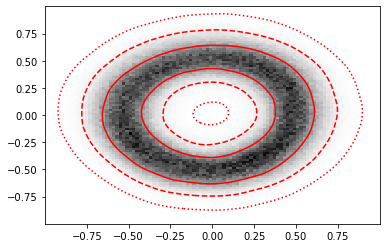

In [14]:
swyft.plot_2d(predictions, "z[0]", "z[1]", bins = 100, smooth = 2, color = 'r', ax = plt.gca(), cmap = 'gray_r');

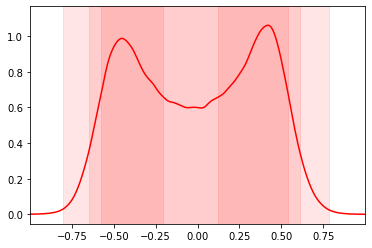

In [20]:
swyft.plot_1d(predictions, "z[0]", bins = 500, smooth = 5, color = 'r', ax = plt.gca());

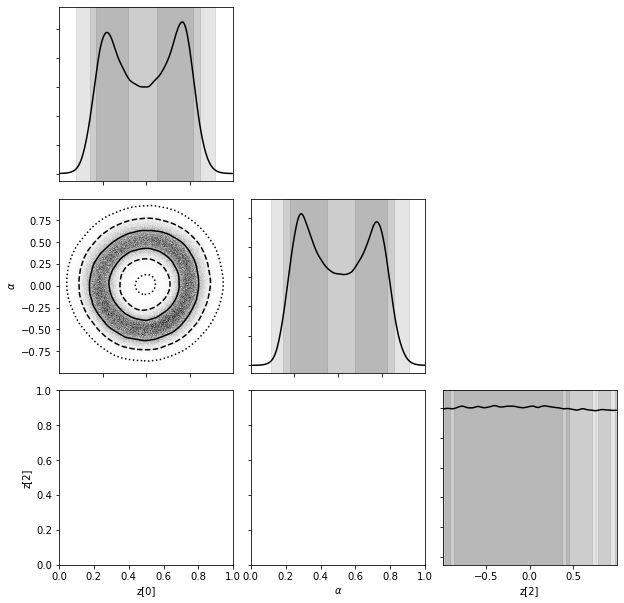

In [24]:
labeler = {'z[1]': r"$\alpha$"}
swyft.corner(predictions, ['z[0]', 'z[1]', 'z[2]'], labeler = labeler, bins = 200, smooth = 3);